In [2]:
from myosuite.utils import gym
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.distributions import Normal
from sac import SAC

(array([-0.5565357 , -0.8308237 ,  0.15649454], dtype=float32), -4.7446397888947525, False, False, {})
(array([-0.5912615 , -0.80647993, -0.66095054], dtype=float32), -4.714958774350294, False, False, {})
(array([-0.6846922 , -0.72883236, -1.4474485 ], dtype=float32), -5.171628953972401, False, False, {})
(array([-0.81664115, -0.5771458 , -2.2080898 ], dtype=float32), -6.168491048950287, False, False, {})
(array([-0.9389968 , -0.34392598, -2.7787106 ], dtype=float32), -7.658046972432447, False, False, {})
(array([-0.99897426, -0.04528201, -3.0923262 ], dtype=float32), -9.567987654596294, False, False, {})
(array([-0.9678799,  0.251413 , -2.8833854], dtype=float32), -10.155926480265832, False, False, {})
(array([-0.8879481 ,  0.45994362, -2.03967   ], dtype=float32), -8.242932252893837, False, False, {})
(array([-0.8224195 ,  0.56888145, -1.0340801 ], dtype=float32), -6.926893301274454, False, False, {})
(array([-8.0560005e-01,  5.9245974e-01,  5.6595221e-04], dtype=float32), -6.3217773

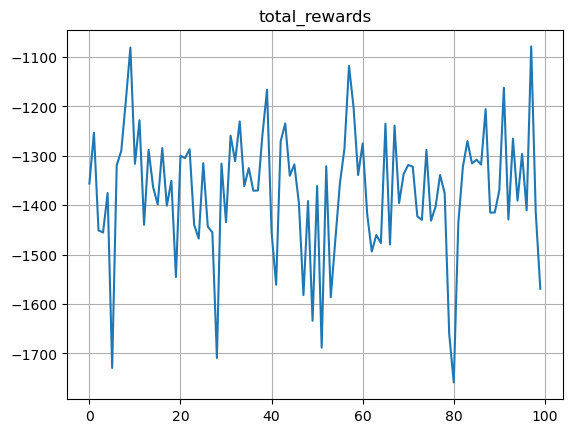

In [3]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = SAC(state_dim, action_dim)

episode_n = 100

total_rewards = []
for episode in range(episode_n):

    total_reward = 0
    state = env.reset()[0]
    
    for t in range(200):
        action = agent.get_action(state)
        print(env.step((action + 1) / 2))
        next_state, reward, done, _ , _ = env.step(2 * action)
    
  
        total_reward += reward
        state = next_state

    total_rewards.append(total_reward)

plt.plot(total_rewards)
plt.title('total_rewards')
plt.grid()
plt.show()

In [ ]:

def train(agent, env, episode_n=10000, max_steps=1000):
    """
    Обучает агента в заданной среде.

    Args:
        agent: SAC.
        env: Gym 
        episode_n (int): Counts of episodes.
        max_steps (int): Max counts of steps in episode.

    Returns:
        list: Max reward.
    """
    total_rewards = []
    running_reward = []
    best_avg_reward = -float('inf')

    for episode in range(episode_n):
        total_reward = 0
        state, _ = env.reset()
        
        for t in range(max_steps):
            action = agent.get_action(state)
            # Scale action from [-1, 1] to [0, 1]
            scaled_action = (action + 1) / 2
            next_state, reward, done, _, _ = env.step(scaled_action)
        
            agent.fit(state, action, reward, done, next_state)
        
            total_reward += reward
            state = next_state
            
            # Optional rendering for debugging (uncomment to enable)
            # env.unwrapped.mj_render()
            
            if done:
                break
        
        total_rewards.append(total_reward)
        running_reward.append(total_reward)
        if len(running_reward) > 10:
            running_reward.pop(0)
        
        # Compute average reward
        avg_reward = np.mean(running_reward)
        
        
        print(f'Episode {episode}: Total Reward = {total_reward}')

    return total_rewards

def main():
    
    # Initialize environment
    env = gym.make('myoLegWalk-v0')
    print(f'Environment name: {env.unwrapped.spec.id}')
    state_dim = env.observation_space.shape[0]
    print(f'Observation space: {env.observation_space.shape[0]}')
    action_dim = env.action_space.shape[0]
    print(f'Action space: {env.action_space.shape[0]}')

    # Initialize SAC agent
    agent = SAC(
        state_dim=state_dim,
        action_dim=action_dim,
        gamma=0.99,
        alpha=0.2,
        tau=0.005,
        batch_size=256,
        pi_lr=1e-4,
        q_lr=1e-4
    )


    # Set up visualization (make skin transparent)
    geom_1_indices = np.where(env.unwrapped.sim.model.geom_group == 1)
    env.unwrapped.sim.model.geom_rgba[geom_1_indices, 3] = 0

    # Train the agent
    total_rewards = train(agent, env)

    # Close environment
    env.close()

    # Plot rewards
    plt.plot(total_rewards)
    plt.title('Total Rewards')
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()